In [1]:
# Import necessary libraries
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import random
import warnings

from torch.utils.data import DataLoader

# Add utility paths
sys.path.append(os.path.join(os.getcwd(), 'utils'))

# Import utility functions
from utils.data_loading import *
from utils.data_processing import *
from utils.simple_vae import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# Enable autoreload
%reload_ext autoreload
%autoreload 2

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define data path
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')
print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Load the linear_vae_model.pth
model_path = os.path.join(current_dir, 'models', 'linear_vae_model.pth')
print(f"Loading model: {model_path}")

# Initialize the SIMPLEVAE model with appropriate parameters
input_dims = (165, 6523)  # Example dimensions, adjust as needed
z_dim = 10
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
linear_vae_model = SIMPLEVAE(input_dims=input_dims, z_dim=z_dim, device=device)
linear_vae_model.load_state_dict(torch.load(model_path))
linear_vae_model.to(device)
linear_vae_model.eval()

# Load the data
filename = os.path.join(data_path, 'ssp585_time_series.pkl')
data, nan_mask = preprocess_data(data_path, filename)

Loading model: /Users/lharriso/Documents/GitHub/gm4cs-l/models/linear_vae_model.pth
Loading data from /Users/lharriso/Documents/GitHub/gm4cs-l/data/ssp585_time_series.pkl
Data loaded successfully.
Filtering data...


100%|██████████| 72/72 [00:00<00:00, 56069.42it/s]

Data filtered. Kept 34 models
Creating NaN mask...



100%|██████████| 34/34 [00:02<00:00, 13.63it/s]

NaN mask created.
Masking out NaN values...



100%|██████████| 34/34 [00:01<00:00, 25.69it/s]

NaN values masked out.
Reshaping data...



100%|██████████| 34/34 [00:04<00:00,  8.49it/s]

Data reshaped.
Adding the forced response to the data...



100%|██████████| 34/34 [00:21<00:00,  1.55it/s]

Forced response added.
Removing NaN values from the grid...



100%|██████████| 34/34 [00:02<00:00, 13.19it/s]

NaN values removed.


In [3]:
# Select one of the models randomly for testing
random_model = random.choice(list(data.keys()))
test_data = {random_model: data[random_model]}

train_models = [model for model in data.keys() if model != random_model]

# Create the training and testing datasets
train_data = {model: data[model] for model in train_models}

# Normalize the test data
center = True
_, normalized_test_data, _, _ = normalize_data(train_data, test_data, center=center)

# Create dataset for the linear VAE
test_dataset = ClimateDataset(normalized_test_data)

# Create dataloader
batch_size = 16  # Higher batch size for linear VAE
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Testing model: {random_model}")

# Select a random input from the data
random_run = random.choice(list(data[random_model].keys()))
input_data = data[random_model][random_run]
input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension and move to device
print(f"Selected model: {random_model}, run: {random_run}, input shape: {input_tensor.shape}")


Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

Data normalization completed.


Creating datasets...


Processing models: 100%|██████████| 1/1 [00:00<00:00, 15141.89it/s]

Testing model: AWI-CM-1-1-MR
Selected model: AWI-CM-1-1-MR, run: r5i1p1f1, input shape: torch.Size([1, 165, 6523])


In [17]:
# Chose a grid cell to plot
row_cell = 35
col_cell = 35
print(f"Selected grid cell: ({row_cell}, {col_cell})")

Selected grid cell: (35, 35)


Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...


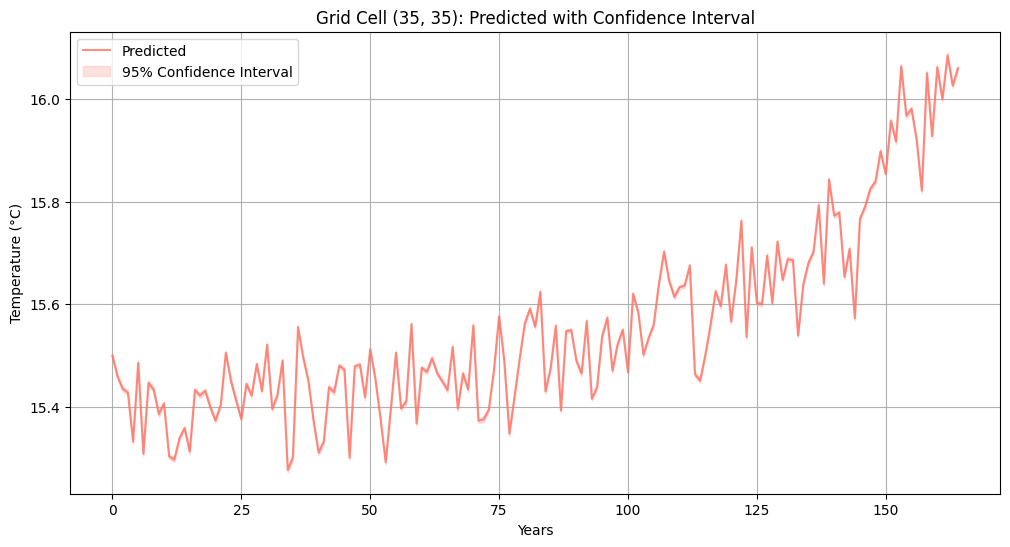

In [18]:
# Define feat_dim and seq_len
seq_len, feat_dim = input_tensor.shape[1], input_tensor.shape[2]

# Generate confidence intervals
mean_prediction, lower_bound, upper_bound = generate_confidence_interval(linear_vae_model, input_tensor, num_samples=50)

# Re-add NaNs to the grid for plotting
mean_prediction_grid = readd_nans_to_grid(mean_prediction[0], nan_mask, predictions=True).reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
lower_bound_grid = readd_nans_to_grid(lower_bound[0], nan_mask, predictions=True).reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
upper_bound_grid = readd_nans_to_grid(upper_bound[0], nan_mask, predictions=True).reshape(-1, nan_mask.shape[0], nan_mask.shape[1])

# Time axis for plotting
time_axis = np.arange(seq_len)

# Plot the confidence interval for the selected grid cell
plt.figure(figsize=(12, 6))
plt.plot(time_axis, mean_prediction_grid[:, row_cell, col_cell], label='Predicted', color='#FF6F61', linewidth=1.5, alpha=0.8)
plt.fill_between(
    time_axis,
    lower_bound_grid[:, row_cell, col_cell],
    upper_bound_grid[:, row_cell, col_cell],
    color='#FF6F61',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.title(f'Grid Cell ({row_cell}, {col_cell}): Predicted with Confidence Interval')
plt.xlabel('Years')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

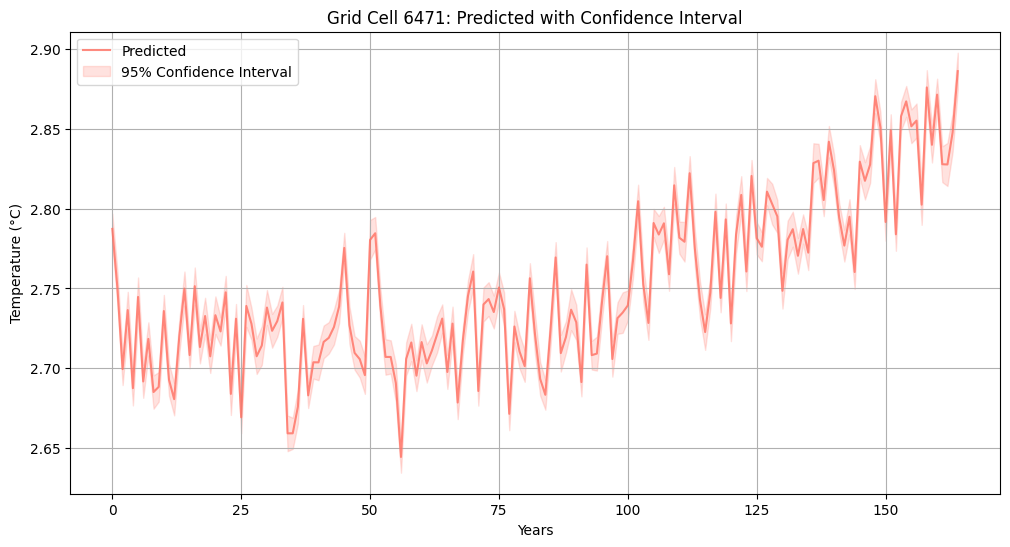

In [24]:
# Define feat_dim and seq_len
seq_len, feat_dim = input_tensor.shape[1], input_tensor.shape[2]

# Generate confidence intervals
mean_prediction, lower_bound, upper_bound = generate_confidence_interval(linear_vae_model, input_tensor, num_samples=50)

# Plot the confidence interval for a random grid cell
random_cell = random.randint(0, feat_dim - 1)
time_axis = np.arange(seq_len)  # Time axis for plotting

plt.figure(figsize=(12, 6))
plt.plot(time_axis, mean_prediction[0, :, random_cell], label='Predicted', color='#FF6F61', linewidth=1.5, alpha=0.8)
plt.fill_between(
    time_axis,
    lower_bound[0, :, random_cell],
    upper_bound[0, :, random_cell],
    color='#FF6F61',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.title(f'Grid Cell {random_cell}: Predicted with Confidence Interval')
plt.xlabel('Years')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Generate animation for the standard deviation evolution

# Re-add NaNs to the grid
std_data = readd_nans_to_grid(mean_prediction.std(axis=0), nan_mask, predictions=True)

# Reshape std_data
std_data = std_data.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])

# Generate animation
std_animation = animate_data(
    std_data,
    title='Time Evolution of Standard Deviation',
    interval=200,
    cmap='viridis',
    color_limits=(std_data.min(), std_data.max())
)

# Save and display the animation
save_path = os.path.join(current_dir, 'animations')
if not os.path.exists(save_path):
    os.makedirs(save_path)
std_animation.save(f"{save_path}/vae_std_evolution.mp4", writer='ffmpeg', fps=15)
print(f"Animation saved to {save_path}/vae_std_evolution.mp4")

from IPython.display import HTML
display(HTML(std_animation.to_html5_video()))

Re-adding NaN values to the grid...
Animation saved to /Users/lharriso/Documents/GitHub/gm4cs-l/animations/vae_std_evolution.mp4
